In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from acessar_dados_curated import carregar_parquets_em_variaveis
import seaborn as sns
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [2]:
carregar_parquets_em_variaveis(destino=globals(), nomes=["clientes_desde", "codigos_paises","contratacoes_ultimos_12_meses", "dados_clientes","historico",
                                                          "mrr","nps_relacional", "nps_transacional_aquisicao","nps_transacional_implantacao", 
                                                          "nps_transacional_onboarding","nps_transacional_produto", "nps_transacional_suporte",
                                                          "tickets", "telemetria_consolidado"])

clientes_desde ← silver/tb_clientes_desde/clientes_desde.parquet  | 10615 linhas
codigos_paises ← silver/codigos_paises/codigos_paises.parquet  | 249 linhas
contratacoes_ultimos_12_meses ← silver/tb_contratacoes_12m/contratacoes_ultimos_12_meses.parquet  | 4314 linhas
dados_clientes ← silver/tb_dados_clientes/dados_clientes.parquet  | 238597 linhas
historico ← silver/tb_historico/historico.parquet  | 22740 linhas
mrr ← silver/tb_mrr/mrr.parquet  | 7309 linhas
nps_relacional ← silver/tb_nps_relacional/nps_relacional.parquet  | 13942 linhas
nps_transacional_aquisicao ← silver/tb_nps_aquisicao/nps_transacional_aquisicao.parquet  | 175 linhas
nps_transacional_implantacao ← silver/tb_nps_implantacao/nps_transacional_implantacao.parquet  | 662 linhas
nps_transacional_onboarding ← silver/tb_nps_onboarding/nps_transacional_onboarding.parquet  | 208 linhas
nps_transacional_produto ← silver/tb_nps_produto/nps_transacional_produto.parquet  | 113201 linhas
nps_transacional_suporte ← silver/tb_nps_

{'clientes_desde': 's3://arcana-fiap/silver/tb_clientes_desde/clientes_desde.parquet',
 'codigos_paises': 's3://arcana-fiap/silver/codigos_paises/codigos_paises.parquet',
 'contratacoes_ultimos_12_meses': 's3://arcana-fiap/silver/tb_contratacoes_12m/contratacoes_ultimos_12_meses.parquet',
 'dados_clientes': 's3://arcana-fiap/silver/tb_dados_clientes/dados_clientes.parquet',
 'historico': 's3://arcana-fiap/silver/tb_historico/historico.parquet',
 'mrr': 's3://arcana-fiap/silver/tb_mrr/mrr.parquet',
 'nps_relacional': 's3://arcana-fiap/silver/tb_nps_relacional/nps_relacional.parquet',
 'nps_transacional_aquisicao': 's3://arcana-fiap/silver/tb_nps_aquisicao/nps_transacional_aquisicao.parquet',
 'nps_transacional_implantacao': 's3://arcana-fiap/silver/tb_nps_implantacao/nps_transacional_implantacao.parquet',
 'nps_transacional_onboarding': 's3://arcana-fiap/silver/tb_nps_onboarding/nps_transacional_onboarding.parquet',
 'nps_transacional_produto': 's3://arcana-fiap/silver/tb_nps_produto/np

In [3]:
df_clientes_desde = clientes_desde
df_codigos_paises = codigos_paises
df_contratacoes_ultimos_12_meses = contratacoes_ultimos_12_meses
df_dados_clientes = dados_clientes
df_historico = historico
df_mrr = mrr
df_nps_relacional = nps_relacional
df_nps_transacional_aquisicao = nps_transacional_aquisicao
df_nps_transacional_implantacao = nps_transacional_implantacao
df_nps_transacional_onboarding = nps_transacional_onboarding
df_nps_transacional_produto = nps_transacional_produto
df_nps_transacional_suporte = nps_transacional_suporte
df_telemetria_consolidado = telemetria_consolidado
df_tickets = tickets

In [4]:
# Janela de observação
HOJE = pd.to_datetime("today")

# Base mestre: clientes únicos
base = df_clientes_desde.copy()


base["TEMPO_CONTRATO_DIAS"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days)
base["TEMPO_CONTRATO_MESES"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days // 30)
base["TEMPO_CONTRATO_ANOS"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days // 365)

base.head()

,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS
0,TFDICB,2023-01-27,961,32,2
1,TFCU91,2021-01-26,1692,56,4
2,TFDDYV,2022-07-18,1154,38,3
3,TEZBRW,2022-10-28,1052,35,2
4,TEZCXN,2013-05-24,4496,149,12


In [74]:
# Removendo os 2 últimos caracteres
df_telemetria_consolidado["COD_CLIENTE"] = df_telemetria_consolidado["COD_CLIENTE"].str[:-2]

In [75]:
df_telemetria_consolidado

,COD_CLIENTE,DURACAO_EVENTO,ID_MODULO,ID_LINHA_PRODUTO,DATA_REFERENCIA,ID_SLOT,STATUS_LICENCA,CLOUD,CLIENTE_PRIME
0,TEXKCV,580.724,6,2,2025-03-19,4133,Desconectado,NaN,NaN
1,TAAHTU,414787.069,6,2,2025-03-19,4000,Desconectado,NaN,NaN
2,TEXKCV,4933.511,6,2,2025-03-19,4133,Desconectado,NaN,NaN
3,TEWERU,414086.474,7,2,2025-03-19,4000,Desconectado,NaN,NaN
4,TFDFHJ,0.000,524,3,2025-03-19,0,Desconectado,NaN,NaN
...,...,...,...,...,...,...,...,...,...
30804192,TDC0GU,180.000,726,9,2025-03-18,3502,Desconectado,NaN,NaN
30804193,TDC0GU,120.000,726,9,2025-03-18,3502,Desconectado,NaN,NaN
30804194,T46457,1349.000,534,3,2025-03-18,534,Desconectado,NaN,NaN
30804195,T43087,61.000,534,3,2025-03-18,534,Desconectado,NaN,NaN


Funções de agregação por tabela

In [76]:
# DADOS_CLIENTES

def agg_dados_clientes(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_produtos=("DS_PROD", "nunique"),
        vl_total_contrato=("VL_TOTAL_CONTRATO", "sum"),
        segmento=("DS_SEGMENTO", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        subsegmento=("DS_SUBSEGMENTO", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        porte=("FAT_FAIXA", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        modal_comercio=("MODAL_COMERC", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
    ).reset_index()
    return out

def agg_contratacoes_12m(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_contratos_12m=("QT_CONTRATACOES_12M", "sum"),
        vl_contratos_12m=("VL_CONTRATACOES_12M", "sum")
    ).reset_index()
    out["contratou_ult_12m"] = (out["n_contratos_12m"] > 0).astype(int)
    return out


def agg_nps_geral(df, prefixo):
    # Colunas numéricas de nota
    num_cols = [c for c in df.columns if c.startswith("NOTA")]
    grp = df.groupby("COD_CLIENTE")
    out = grp[num_cols].mean().add_prefix(f"{prefixo}_").reset_index()
    out[f"{prefixo}_respondeu"] = grp.size().reset_index(name="n")["n"].astype(int)
    out[f"{prefixo}_respondeu"] = (out[f"{prefixo}_respondeu"]>0).astype(int)
    return out


def agg_telemetria(df):
    out = df.groupby("COD_CLIENTE").agg(
        tele_eventos=("DURACAO_EVENTO","count"),
        tele_modulos=("ID_MODULO","nunique"),
        tele_linhas_produto=("ID_LINHA_PRODUTO","nunique"),
    ).reset_index()
    return out


def agg_tickets(df):
    # indicador de crítico
    if "PRIORIDADE_TICKET" in df.columns:
        df["is_critico"] = df["PRIORIDADE_TICKET"].astype(str).str.lower().isin(["low","normal","high","urgent"]).astype(int)
    else:
        df["is_critico"] = 0

    out = df.groupby("COD_CLIENTE").agg(
        n_tickets=("BK_TICKET","count"),
        pct_tickets_criticos=("is_critico","mean")
    ).reset_index()
    return out


def agg_historico(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_propostas=("NR_PROPOSTA","nunique"),
        vl_total_propostas=("VL_TOTAL","sum"),
        prc_unitario_medio=("PRC_UNITARIO","mean")
    ).reset_index()
    return out

In [78]:
def left_merge(a, b, on="COD_CLIENTE"):
    return a.merge(b, on=on, how="left")

# Agregações
agg_dc   = agg_dados_clientes(df_dados_clientes)
agg_ct12 = agg_contratacoes_12m(df_contratacoes_ultimos_12_meses)
agg_mrr_ = df_mrr

agg_nps_rel = agg_nps_geral(df_nps_relacional, "nps_rel")
agg_nps_aq  = agg_nps_geral(df_nps_transacional_aquisicao, "nps_aquis")
agg_nps_impl= agg_nps_geral(df_nps_transacional_implantacao, "nps_impl")
agg_nps_onb = agg_nps_geral(df_nps_transacional_onboarding, "nps_onb")
agg_nps_sup = agg_nps_geral(df_nps_transacional_suporte, "nps_sup")

agg_tel  = agg_telemetria(df_telemetria_consolidado)
agg_tic  = agg_tickets(df_tickets)
agg_hist = agg_historico(df_historico)

# Join Geral
df = base.copy()
for part in [agg_dc, agg_ct12, agg_mrr_, agg_nps_rel, agg_nps_aq, agg_nps_impl, agg_nps_onb, agg_nps_sup, agg_tel, agg_tic, agg_hist]:
    df = left_merge(df, part)

# Faltantes → 0 para contagens/somas; deixam NaN para médias de NPS/valores
count_cols = [
    "n_produtos","n_contratos_12m","contratou_ult_12m","tele_eventos","tele_modulos","tele_linhas_produto",
    "n_tickets","n_propostas"
]
for c in count_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# Flags respondeu NPS (se não tiver, vira 0)
for c in [col for col in df.columns if c.endswith("_respondeu")]:
    df[c] = df[c].fillna(0).astype(int)

print(df.shape)
df.head()

(10615, 62)


,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,subsegmento,porte,...,nps_sup_NOTA_SATISFACAO,nps_sup_respondeu,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio
0,TFDICB,2023-01-27,961,32,2,7,12899.477479,VAREJO,CONCESSIONARIA DE VEICULOS,Faixa 03 - De 15 M ate 25 M,...,NaN,NaN,0.0,0.0,0.0,369.0,1.0,0.0,NaN,NaN
1,TFCU91,2021-01-26,1692,56,4,5,8271.379438,LOGISTICA,TRANSPORTADOR,"Faixa 00 - Ate 4,5 M",...,NaN,NaN,363.0,9.0,2.0,68.0,1.0,0.0,NaN,NaN
2,TFDDYV,2022-07-18,1154,38,3,7,94240.254204,MANUFATURA,METAL-MECANICO & PLASTICO,Sem Informações de Faturamento,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
3,TEZBRW,2022-10-28,1052,35,2,1,0.008408,SERVICOS,PROVEDOR DE SERVICOS,Sem Informações de Faturamento,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
4,TEZCXN,2013-05-24,4496,149,12,45,103720.024034,MANUFATURA,METAL-MECANICO & PLASTICO,Faixa 07 - De 75 M ate 150 M,...,9.896,1.0,17771.0,40.0,3.0,709.0,1.0,7.0,44989.370466,1482.566496


In [79]:
df.isnull().sum()

COD_CLIENTE                0
DATA_CLIENTE_DESDE         0
TEMPO_CONTRATO_DIAS        0
TEMPO_CONTRATO_MESES       0
TEMPO_CONTRATO_ANOS        0
                        ... 
n_tickets                  0
pct_tickets_criticos    3742
n_propostas                0
vl_total_propostas      6562
prc_unitario_medio      6562
Length: 62, dtype: int64

In [80]:
df.columns

Index(['COD_CLIENTE', 'DATA_CLIENTE_DESDE', 'TEMPO_CONTRATO_DIAS',
       'TEMPO_CONTRATO_MESES', 'TEMPO_CONTRATO_ANOS', 'n_produtos',
       'vl_total_contrato', 'segmento', 'subsegmento', 'porte',
       'modal_comercio', 'n_contratos_12m', 'vl_contratos_12m',
       'contratou_ult_12m', 'MRR_12M', 'nps_rel_NOTA_NPS',
       'nps_rel_NOTA_RESPOSTA_UNIDADE', 'nps_rel_NOTA_SUPTEC_AGILIDADE',
       'nps_rel_NOTA_SUPTEC_ATENDIMENTO', 'nps_rel_NOTA_COMERCIAL',
       'nps_rel_NOTA_CUSTOS', 'nps_rel_NOTA_ADMFIN_ATENDIMENTO',
       'nps_rel_NOTA_SOFTWARE', 'nps_rel_NOTA_SOFTWARE_ATUALIZACAO',
       'nps_rel_respondeu', 'nps_aquis_NOTA_NPS', 'nps_aquis_NOTA_AGILIDADE',
       'nps_aquis_NOTA_CONHECIMENTO', 'nps_aquis_NOTA_CUSTO',
       'nps_aquis_NOTA_FACILIDADE', 'nps_aquis_NOTA_FLEXIBILIDADE',
       'nps_aquis_respondeu', 'nps_impl_NOTA_NPS', 'nps_impl_NOTA_METODOLOGIA',
       'nps_impl_NOTA_GESTAO', 'nps_impl_NOTA_CONHECIMENTO',
       'nps_impl_NOTA_QUALIDADE', 'nps_impl_NOTA_COMUN

In [81]:
# Exibir apenas os nomes das colunas sem valores nulos
colunas_sem_nulos = df.columns[df.notnull().all()]
print(colunas_sem_nulos)

Index(['COD_CLIENTE', 'DATA_CLIENTE_DESDE', 'TEMPO_CONTRATO_DIAS',
       'TEMPO_CONTRATO_MESES', 'TEMPO_CONTRATO_ANOS', 'n_produtos',
       'vl_total_contrato', 'segmento', 'porte', 'n_contratos_12m',
       'contratou_ult_12m', 'tele_eventos', 'tele_modulos',
       'tele_linhas_produto', 'n_tickets', 'n_propostas'],
      dtype='object')


In [82]:
# DEFININDO FEATURES FINAIS

df_final = df.copy()

df_final = df_final[["COD_CLIENTE", "TEMPO_CONTRATO_ANOS", "n_produtos", "vl_total_contrato", "segmento", "porte", "n_contratos_12m", "tele_eventos", "n_tickets", "n_propostas"]]

In [83]:
df['segmento'].unique()

array(['VAREJO', 'LOGISTICA', 'MANUFATURA', 'SERVICOS', 'DISTRIBUICAO',
       'CONSTRUCAO E PROJETOS', 'EDUCACIONAL', 'AGROINDUSTRIA',
       'HOSPITALITY', 'SAUDE', 'TOTVS', 'JURIDICO', 'FINANCIAL SERVICES',
       'SUPERMERCADOS'], dtype=object)

In [84]:
df['segmento'].value_counts()

segmento
SERVICOS                 2424
VAREJO                   2185
MANUFATURA               2072
DISTRIBUICAO              861
CONSTRUCAO E PROJETOS     702
LOGISTICA                 650
HOSPITALITY               567
EDUCACIONAL               527
SAUDE                     298
AGROINDUSTRIA             204
JURIDICO                  111
FINANCIAL SERVICES         10
TOTVS                       2
SUPERMERCADOS               2
Name: count, dtype: int64

In [101]:
df['porte'].value_counts()

porte
Sem Informações de Faturamento    5059
Faixa 00 - Ate 4,5 M              1624
Faixa 02 - De 7,5 M ate 15 M       733
Faixa 03 - De 15 M ate 25 M        580
Faixa 01 - De 4,5 M ate 7,5 M      520
Faixa 07 - De 75 M ate 150 M       442
Faixa 04 - De 25 M ate 35 M        365
Faixa 06 - De 50 M ate 75 M        346
Faixa 05 - De 35 M ate 50 M        311
Faixa 08 - De 150 M ate 300 M      303
Faixa 09 - De 300 M ate 500 M      141
Faixa 11 - Acima de 850 M          115
Faixa 10 - De 500 M ate 850 M       76
Name: count, dtype: int64

In [85]:
df['porte'].unique()

array(['Faixa 03 - De 15 M ate 25 M', 'Faixa 00 - Ate 4,5 M',
       'Sem Informações de Faturamento', 'Faixa 07 - De 75 M ate 150 M',
       'Faixa 05 - De 35 M ate 50 M', 'Faixa 09 - De 300 M ate 500 M',
       'Faixa 02 - De 7,5 M ate 15 M', 'Faixa 01 - De 4,5 M ate 7,5 M',
       'Faixa 11 - Acima de 850 M', 'Faixa 08 - De 150 M ate 300 M',
       'Faixa 04 - De 25 M ate 35 M', 'Faixa 06 - De 50 M ate 75 M',
       'Faixa 10 - De 500 M ate 850 M'], dtype=object)

In [86]:
dict_porte = {
    'Sem Informações de Faturamento': 0,
    'Faixa 00 - Ate 4,5 M': 1,
    'Faixa 01 - De 4,5 M ate 7,5 M': 2,
    'Faixa 02 - De 7,5 M ate 15 M': 3,
    'Faixa 03 - De 15 M ate 25 M': 4,
    'Faixa 04 - De 25 M ate 35 M': 5,
    'Faixa 05 - De 35 M ate 50 M': 6,
    'Faixa 06 - De 50 M ate 75 M': 7,
    'Faixa 07 - De 75 M ate 150 M': 8,
    'Faixa 08 - De 150 M ate 300 M': 9,
    'Faixa 09 - De 300 M ate 500 M': 10,
    'Faixa 10 - De 500 M ate 850 M': 11,
    'Faixa 11 - Acima de 850 M': 12
}

df_final['PORTE_CLASSIFICACAO'] = df['porte'].map(dict_porte)

In [87]:
df_final

,COD_CLIENTE,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,porte,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO
0,TFDICB,2,7,12899.477479,VAREJO,Faixa 03 - De 15 M ate 25 M,0.0,0.0,369.0,0.0,4
1,TFCU91,4,5,8271.379438,LOGISTICA,"Faixa 00 - Ate 4,5 M",0.0,363.0,68.0,0.0,1
2,TFDDYV,3,7,94240.254204,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0
3,TEZBRW,2,1,0.008408,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0
4,TEZCXN,12,45,103720.024034,MANUFATURA,Faixa 07 - De 75 M ate 150 M,3.0,17771.0,709.0,7.0,8
...,...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,2,1,64.873927,VAREJO,Sem Informações de Faturamento,0.0,0.0,29.0,0.0,0
10611,TFBYAZ,20,36,17197.660999,HOSPITALITY,Sem Informações de Faturamento,0.0,0.0,67.0,1.0,0
10612,T04630,28,36,54783.508954,SERVICOS,"Faixa 02 - De 7,5 M ate 15 M",0.0,0.0,7.0,0.0,3
10613,TFCIUB,6,10,70668.675237,SERVICOS,Faixa 07 - De 75 M ate 150 M,0.0,4.0,5.0,0.0,8


In [183]:
features_para_modelo = df_final.drop(['COD_CLIENTE', 'porte'], axis=1)

In [184]:
features_para_modelo

,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO
0,2,7,12899.477479,VAREJO,0.0,0.0,369.0,0.0,4
1,4,5,8271.379438,LOGISTICA,0.0,363.0,68.0,0.0,1
2,3,7,94240.254204,MANUFATURA,0.0,0.0,0.0,0.0,0
3,2,1,0.008408,SERVICOS,0.0,0.0,0.0,0.0,0
4,12,45,103720.024034,MANUFATURA,3.0,17771.0,709.0,7.0,8
...,...,...,...,...,...,...,...,...,...
10610,2,1,64.873927,VAREJO,0.0,0.0,29.0,0.0,0
10611,20,36,17197.660999,HOSPITALITY,0.0,0.0,67.0,1.0,0
10612,28,36,54783.508954,SERVICOS,0.0,0.0,7.0,0.0,3
10613,6,10,70668.675237,SERVICOS,0.0,4.0,5.0,0.0,8


In [185]:
features_para_modelo = pd.get_dummies(features_para_modelo, columns=['segmento'])

In [186]:
features_para_modelo

,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO,segmento_AGROINDUSTRIA,segmento_CONSTRUCAO E PROJETOS,...,segmento_FINANCIAL SERVICES,segmento_HOSPITALITY,segmento_JURIDICO,segmento_LOGISTICA,segmento_MANUFATURA,segmento_SAUDE,segmento_SERVICOS,segmento_SUPERMERCADOS,segmento_TOTVS,segmento_VAREJO
0,2,7,12899.477479,0.0,0.0,369.0,0.0,4,False,False,...,False,False,False,False,False,False,False,False,False,True
1,4,5,8271.379438,0.0,363.0,68.0,0.0,1,False,False,...,False,False,False,True,False,False,False,False,False,False
2,3,7,94240.254204,0.0,0.0,0.0,0.0,0,False,False,...,False,False,False,False,True,False,False,False,False,False
3,2,1,0.008408,0.0,0.0,0.0,0.0,0,False,False,...,False,False,False,False,False,False,True,False,False,False
4,12,45,103720.024034,3.0,17771.0,709.0,7.0,8,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10610,2,1,64.873927,0.0,0.0,29.0,0.0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
10611,20,36,17197.660999,0.0,0.0,67.0,1.0,0,False,False,...,False,True,False,False,False,False,False,False,False,False
10612,28,36,54783.508954,0.0,0.0,7.0,0.0,3,False,False,...,False,False,False,False,False,False,True,False,False,False
10613,6,10,70668.675237,0.0,4.0,5.0,0.0,8,False,False,...,False,False,False,False,False,False,True,False,False,False


In [132]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_para_modelo)

print(f"\nFormato dos dados padronizados (linhas, colunas): {X_scaled.shape}")


Formato dos dados padronizados (linhas, colunas): (10615, 7)



Calculando AIC e BIC para diferentes números de clusters...


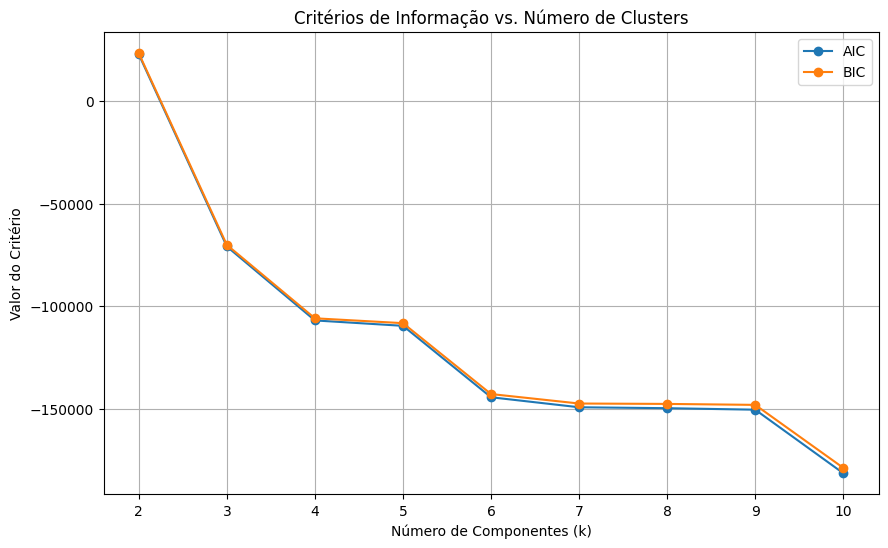


Número ideal de clusters (k) encontrado pelo BIC: 8


In [133]:
n_components = range(2, 11) # Testaremos de 2 a 10 clusters
aics = []
bics = []

print("\nCalculando AIC e BIC para diferentes números de clusters...")
for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X_scaled)
    aics.append(gmm.aic(X_scaled))
    bics.append(gmm.bic(X_scaled))

# Plotando os resultados do AIC e BIC
plt.figure(figsize=(10, 6))
plt.plot(n_components, aics, marker='o', label='AIC')
plt.plot(n_components, bics, marker='o', label='BIC')
plt.title('Critérios de Informação vs. Número de Clusters')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Valor do Critério')
plt.legend()
plt.grid(True)
plt.show()

# Escolhendo o k com o menor valor de BIC, que geralmente é mais rigoroso.
optimal_k = bics.index(min(bics)) 
print(f"\nNúmero ideal de clusters (k) encontrado pelo BIC: {optimal_k}")


Calculando métricas de avaliação de cluster...


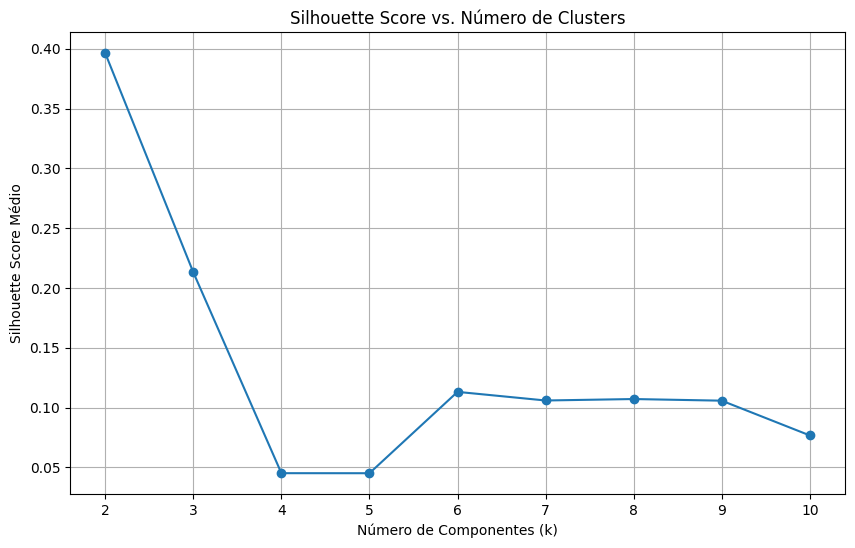


Melhor k de acordo com o Silhouette Score: 2


In [134]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

k_range = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("\nCalculando métricas de avaliação de cluster...")
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    
    # Calcular e armazenar as pontuações
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

# Plotar o Silhouette Score (geralmente o mais útil)
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Número de Clusters')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Silhouette Score Médio')
plt.grid(True)
plt.show()

# O k com o MAIOR Silhouette Score é considerado o melhor por essa métrica.
best_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nMelhor k de acordo com o Silhouette Score: {best_k_silhouette}")

In [158]:
gmm_final = GaussianMixture(n_components=8, random_state=42, n_init=10, covariance_type='diag')
gmm_final.fit(X_scaled)

# Prevendo os clusters para cada cliente
cluster_labels = gmm_final.predict(X_scaled)

In [159]:
df_clusterizado = df_final.copy()

In [160]:
df_clusterizado['Cluster'] = cluster_labels

In [161]:
df_clusterizado

,COD_CLIENTE,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,porte,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO,Cluster
0,TFDICB,2,7,12899.477479,VAREJO,Faixa 03 - De 15 M ate 25 M,0.0,0.0,369.0,0.0,4,2
1,TFCU91,4,5,8271.379438,LOGISTICA,"Faixa 00 - Ate 4,5 M",0.0,363.0,68.0,0.0,1,2
2,TFDDYV,3,7,94240.254204,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,2
3,TEZBRW,2,1,0.008408,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,0
4,TEZCXN,12,45,103720.024034,MANUFATURA,Faixa 07 - De 75 M ate 150 M,3.0,17771.0,709.0,7.0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,2,1,64.873927,VAREJO,Sem Informações de Faturamento,0.0,0.0,29.0,0.0,0,0
10611,TFBYAZ,20,36,17197.660999,HOSPITALITY,Sem Informações de Faturamento,0.0,0.0,67.0,1.0,0,1
10612,T04630,28,36,54783.508954,SERVICOS,"Faixa 02 - De 7,5 M ate 15 M",0.0,0.0,7.0,0.0,3,2
10613,TFCIUB,6,10,70668.675237,SERVICOS,Faixa 07 - De 75 M ate 150 M,0.0,4.0,5.0,0.0,8,2


In [162]:
# Adicione a contagem de clientes ao perfil para ter tudo em uma única tabela
cluster_profile = df_clusterizado.groupby('Cluster').mean(numeric_only=True)
cluster_profile['N_Clientes'] = df_clusterizado['Cluster'].value_counts()

# Ordene pelo número de clientes para facilitar a análise
print(cluster_profile.sort_values(by='N_Clientes', ascending=False))

         TEMPO_CONTRATO_ANOS  n_produtos  vl_total_contrato  n_contratos_12m  \
Cluster                                                                        
0                   5.608929    4.562798       1.095270e+03         0.000000   
2                  11.668700   15.635151       3.161636e+04         0.000000   
1                  11.767649   21.808773       6.197408e+04         1.605894   
4                   5.570943   10.446899       1.079494e+04         1.362787   
6                   0.644820    5.408034       1.071759e+03         1.084567   
5                  13.200000   37.706818       2.242222e+05         2.936364   
7                  17.366864   65.136095       2.097315e+06         2.798817   
3                  23.000000   83.000000       1.937021e+06         5.000000   

         tele_eventos    n_tickets  n_propostas  PORTE_CLASSIFICACAO  \
Cluster                                                                
0        1.399405e+00     5.855357     0.000000        

In [163]:
df_clusterizado['Cluster'].value_counts()

Cluster
0    3360
2    2623
1    1459
4    1177
6     946
5     880
7     169
3       1
Name: count, dtype: int64

In [164]:
# Ordene pelo número de clientes para facilitar a análise
print(cluster_profile.sort_values(by='Cluster', ascending=True))

         TEMPO_CONTRATO_ANOS  n_produtos  vl_total_contrato  n_contratos_12m  \
Cluster                                                                        
0                   5.608929    4.562798       1.095270e+03         0.000000   
1                  11.767649   21.808773       6.197408e+04         1.605894   
2                  11.668700   15.635151       3.161636e+04         0.000000   
3                  23.000000   83.000000       1.937021e+06         5.000000   
4                   5.570943   10.446899       1.079494e+04         1.362787   
5                  13.200000   37.706818       2.242222e+05         2.936364   
6                   0.644820    5.408034       1.071759e+03         1.084567   
7                  17.366864   65.136095       2.097315e+06         2.798817   

         tele_eventos    n_tickets  n_propostas  PORTE_CLASSIFICACAO  \
Cluster                                                                
0        1.399405e+00     5.855357     0.000000        

In [168]:
df_clusterizado[df_clusterizado["Cluster"] == 7]

,COD_CLIENTE,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,porte,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO,Cluster
25,T10047,16,172,1.488458e+05,MANUFATURA,Faixa 11 - Acima de 850 M,5.0,0.0,45.0,10.0,12,7
31,TA8583,14,46,4.430541e+05,SERVICOS,Faixa 11 - Acima de 850 M,0.0,312657.0,254.0,2.0,12,7
64,T35673,23,70,6.084506e+05,LOGISTICA,Faixa 11 - Acima de 850 M,11.0,277893.0,491.0,13.0,12,7
293,T24827,32,8,1.733354e+06,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,48.0,0.0,0,7
364,TFCLGO,5,11,7.631952e+03,VAREJO,Sem Informações de Faturamento,0.0,0.0,2025.0,0.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
10115,T09269,24,202,1.431959e+05,MANUFATURA,Faixa 06 - De 50 M ate 75 M,0.0,0.0,0.0,0.0,7,7
10238,TEXY99,6,18,8.711965e+04,FINANCIAL SERVICES,"Faixa 02 - De 7,5 M ate 15 M",2.0,93374.0,564.0,2.0,3,7
10268,T61718,17,188,2.152081e+04,SAUDE,Faixa 06 - De 50 M ate 75 M,0.0,0.0,6.0,0.0,7,7
10382,TEZF84,10,7,8.874979e+04,EDUCACIONAL,Faixa 08 - De 150 M ate 300 M,0.0,437275.0,190.0,2.0,9,7


In [187]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
 
gmm = GaussianMixture(n_components=8, random_state=42).fit(features_para_modelo)
baseline = gmm.score(features_para_modelo)  # log-likelihood médio por ponto
 
for col in features_para_modelo.columns:
    X_temp = features_para_modelo.drop(columns=[col])
    gmm_temp = GaussianMixture(n_components=8, random_state=42).fit(X_temp)
    score = gmm_temp.score(X_temp)
    print(col, baseline - score)

TEMPO_CONTRATO_ANOS -2.1494325580114406
n_produtos -3.7579714507998965
vl_total_contrato -18.97568402762328
n_contratos_12m -6.487188991470976
tele_eventos -15.050390236268345
n_tickets -5.103761071596871
n_propostas -6.862465440935448
PORTE_CLASSIFICACAO 0.3964860491863682
segmento_AGROINDUSTRIA 5.412633846385344
segmento_CONSTRUCAO E PROJETOS 5.851883442452072
segmento_DISTRIBUICAO 5.412633775130082
segmento_EDUCACIONAL 5.8843925484871225
segmento_FINANCIAL SERVICES 6.780156278542615
segmento_HOSPITALITY 5.866036889030106
segmento_JURIDICO 5.866036882309697
segmento_LOGISTICA 5.842530304370211
segmento_MANUFATURA 5.404255452181275
segmento_SAUDE 5.842528658685584
segmento_SERVICOS 5.083360144028891
segmento_SUPERMERCADOS 5.883883468727079
segmento_TOTVS 6.780155464348198
segmento_VAREJO 5.403756234027377
